In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [3]:
sequence_length=28
input_size=28
hidden_size=128
num_layers=2

num_classes=10
batch_size=100
num_epochs=2
learning_rate=0.01

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(),
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(),
                      target_transform=None, download=True)

0it [00:00, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


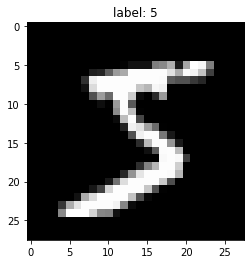

In [8]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

image, label=mnist_train.__getitem__(0)
print("image data 형태: ", image.size())
print("label: ", label)

img=image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
                         batch_size=batch_size,
                         shuffle=True, 
                         drop_last=True)

[0]
한 번에 로드되는 데이터 크기:  100


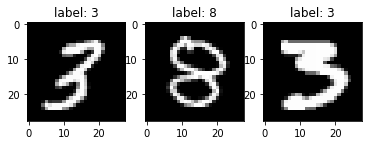

[1]
한 번에 로드되는 데이터 크기:  100


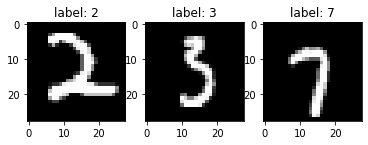

[2]
한 번에 로드되는 데이터 크기:  100


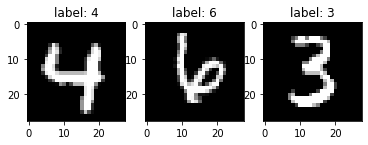

[3]
한 번에 로드되는 데이터 크기:  100


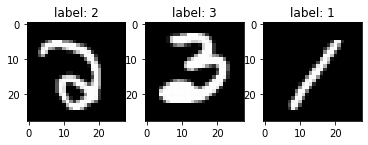

[4]
한 번에 로드되는 데이터 크기:  100


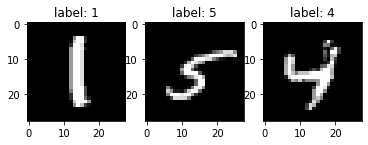

[5]
한 번에 로드되는 데이터 크기:  100


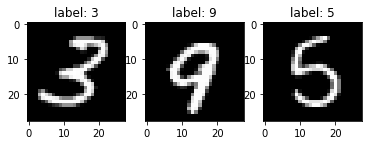

In [11]:
n=3
for i, [imgs, labels] in enumerate(test_loader):
    if i>5:
        break
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기: ", len(imgs))
    
    for j in range(n):
        img=imgs[j].numpy()
        img=img.reshape((img.shape[1], img.shape[2]))
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc=nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0=torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        
        out, _=self.lstm(x, (h0, c0))
        out=self.fc(out[:, -1, :])
        
        return out

In [28]:
model=RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [29]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs, labels] in enumerate(dloader):
        img=imgs
        img=img.reshape(-1, sequence_length, input_size).to(device)
        
        label=labels.to(device)
        
        output=model(img)
        _, output_index=torch.max(output, 1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    return(100*correct/total).numpy()

In [30]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 8.99


In [31]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
total_step=len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        img=imgs
        img=img.reshape(-1, sequence_length, input_size).to(device)
        
        label=labels.to(device)
        
        outputs=model(img)
        loss=loss_func(outputs, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%100==0:
            print("Epch [{}/{}]. Step[{}/{}], Loss: {:.4f}, Accr: {:.2f}"
                 .format(epoch+1, num_epochs, i+1, total_step,
                        loss.item(), ComputeAccr(test_loader, model)))

Epch [1/2]. Step[100/600], Loss: 0.1213, Accr: 94.09
Epch [1/2]. Step[200/600], Loss: 0.2808, Accr: 95.08
Epch [1/2]. Step[300/600], Loss: 0.1457, Accr: 96.08
Epch [1/2]. Step[400/600], Loss: 0.0561, Accr: 96.47
Epch [1/2]. Step[500/600], Loss: 0.0709, Accr: 96.72
Epch [1/2]. Step[600/600], Loss: 0.1785, Accr: 97.15
Epch [2/2]. Step[100/600], Loss: 0.0816, Accr: 97.29
Epch [2/2]. Step[200/600], Loss: 0.0627, Accr: 97.09
Epch [2/2]. Step[300/600], Loss: 0.0679, Accr: 97.12
Epch [2/2]. Step[400/600], Loss: 0.0534, Accr: 97.25
Epch [2/2]. Step[500/600], Loss: 0.0831, Accr: 97.71
Epch [2/2]. Step[600/600], Loss: 0.0182, Accr: 97.77


In [34]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.77


In [35]:
netname='./nets/rnn_weight.pkl'
torch.save(model, netname, )

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [36]:
netname='./nets/rnn_weight.pkl'
model=torch.load(netname)
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.77
